# Исследование закономерностей, определяющих успешность компьютерных игр

Исследование проводится для интернет-магазина, продающего компьютерные игры. Используются данные за 2016 год и ранее, данные предоставлены из открытых источников и содержат информацию о продажах игр, оценках пользователей и экспертов, жанрах и платформах. Необходимо выявить определяющие успешность игры закономерности для выявления потенциально популярных продуктов и прогнозирования рекламной кампании на 2017-й год. 

## Изучение данных из файла

Загрузим библиотеки, которые понадобятся.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import stats as st
from scipy.stats import norm
from scipy.stats import mode
import seaborn as sns 


import warnings
warnings.filterwarnings('ignore')

Прочитаем файл csv и сохраним его

In [2]:
try:
    games = pd.read_csv('/datasets/games.csv')
except:
    games = pd.read_csv('games.csv')
display(games.head(5))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Описание данных

•	Name — название игры

•	Platform — платформа

•	Year_of_Release — год выпуска

•	Genre — жанр игры

•	NA_sales — продажи в Северной Америке (миллионы проданных копий)

•	EU_sales — продажи в Европе (миллионы проданных копий)

•	JP_sales — продажи в Японии (миллионы проданных копий)

•	Other_sales — продажи в других странах (миллионы проданных копий)

•	Critic_Score — оценка критиков (максимум 100)

•	User_Score — оценка пользователей (максимум 10)

•	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


In [3]:
# Общая информация
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Названия столбцов лучше привести к нижнему регистру. Тип данных в столбцах Year_of_Release, User_Score нужно привести к типу int, Year_of_Release - поскольку не задан месяц и день, можно также привести к типу int.

In [4]:
# Количество нулевых строк
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Есть нулевые значения, прежде чем приступить к ислледовательсткому анализу, следует провести предобработку данных.

#### Вывод

Количество ненулевых объектов в строках разное, необходимо будет избавиться от нулевых значений, обработать пропуски. 
Тип данных в столбцах Year_of_Release, User_Score нужно привести к типу int. 
Также необходимо будет проверить данные на дубликаты.

## Предобработка данных

Заменим названия столбцов, приведя к нижнему регистру.

In [5]:
# Приводим к нижнему регистру
games.columns = games.columns.str.lower()

In [6]:
print('Количество записей в name до понижения регистра -', len(games['name'].unique()))
games['name'] = games['name'].str.lower()
print('Количество записей в name после понижения регистра -', len(games['name'].unique()))

Количество записей в name до понижения регистра - 11560
Количество записей в name после понижения регистра - 11560


In [7]:
print('Количество записей в platform до понижения регистра -', len(games['platform'].unique()))
games['platform'] = games['platform'].str.lower()
print('Количество записей в platform после понижения регистра -', len(games['platform'].unique()))

Количество записей в platform до понижения регистра - 31
Количество записей в platform после понижения регистра - 31


Количество уникальных записей в name и platform не поменялось, значит в названиях нет дубликатов из-за разных регистров. Стоило проверить.

In [8]:
#Удаляем 2 строки с неизвестными наименованиями и жанрами
games = games.dropna(subset = ['name'])
games = games.dropna(subset = ['genre'])

In [9]:
games['name'].value_counts()

need for speed: most wanted                                     12
ratatouille                                                      9
fifa 14                                                          9
madden nfl 07                                                    9
lego marvel super heroes                                         9
                                                                ..
nishijin pachinko monogatari 2                                   1
final fantasy crystal chronicles: ring of fates                  1
motogp 2: ultimate racing technology                             1
katekyoo hitman reborn! ds: flame rumble hyper - moeyo mirai     1
jikkyou powerful pro yakuu '94                                   1
Name: name, Length: 11559, dtype: int64

Строк с названием Need for Speed: Most Wanted 12, это значит, например, что они представлены на разных платформах, или есть дубликаты. Выведем строки с этой игрой.

In [10]:
(games.query('name == "need for speed: most wanted"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,need for speed: most wanted,ps2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,need for speed: most wanted,ps3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,need for speed: most wanted,x360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,need for speed: most wanted,x360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,need for speed: most wanted,xb,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,need for speed: most wanted,psv,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,need for speed: most wanted,gc,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,need for speed: most wanted,pc,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,need for speed: most wanted,wiiu,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,need for speed: most wanted,ds,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Пропуски в пользовательских рейтингах user_score и critic_score не будем заполнять - любое заполнение исказит результаты корреляционного анализа и стат-тестов. Пропуски по году релиза в некоторых строках можно попробовать заполнить по наименованию игр. В целом, можно удалить эти строки, поскольку пропущенных значений не так много.
Вероятно, пропуски появились при соединении нескольких таблиц.

In [11]:
#заполняем пропущенные значения в year_of_release, группируя по наименованию и заполняя медианой
print('Пропуски до year_of_release -', games['year_of_release'].isna().sum())
games['year_of_release'] = games['year_of_release'].fillna(games.groupby('name')['year_of_release'].transform('median'))
print('Пропуски после year_of_release -', games['year_of_release'].isna().sum())

Пропуски до year_of_release - 269
Пропуски после year_of_release - 146


In [12]:
#Удалим нулевые строки year_of_release 
games = games.dropna(subset = ['year_of_release'])
print('нулевых строк year_of_release -', games['year_of_release'].isna().sum())
games['year_of_release'] = games['year_of_release'].astype('int')

нулевых строк year_of_release - 0


In [13]:
#Проверка на дубликаты
print('Количество дубликатов -', games.duplicated().sum())

Количество дубликатов - 0


In [14]:
#Проверка типов значений в user_score
games['user_score'].value_counts()

tbd    2394
7.8     324
8       288
8.2     279
8.3     253
       ... 
0.5       2
1.1       2
1.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Тип tbd означает To Be Determined, те значение не определено. Этих данных у нас нет, пропусков много, около 15% от всей таблицы. Заполнить эти строки не получится, любое заполнение исказит результаты, поэтому оставим только те строки, в которых есть user_score. Для анализа, связанного с рейтингами возьмем отдельную таблицу games_sc, где не будет пропущенных данных critic_score, user_score, rating

Посчитаем суммарные продажи во всех регионах, запишем их в отдельный столбец sales

In [15]:
games['rating'].value_counts()

E       3958
T       2930
M       1554
E10+    1412
EC         8
K-A        3
RP         2
AO         1
Name: rating, dtype: int64

In [16]:
#функция суммирует продажи 
def summ_sales(row):
    return(row['na_sales'] + row['eu_sales'] + row['jp_sales'])

#функция суммирует продажи     
games['sales'] = games.apply(summ_sales, axis=1)
games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
899,red faction,ps2,2001,Shooter,0.76,0.96,0.0,0.20,88.0,8,M,1.72
1679,nfl 2k,dc,1999,Sports,1.12,0.05,0.0,0.02,NaN,NaN,NaN,1.17
2798,wwe smackdown vs. raw 2010,wii,2009,Fighting,0.49,0.17,0.0,0.06,78.0,7.7,T,0.66
3267,start the party!,ps3,2010,Misc,0.07,0.41,0.0,0.13,NaN,NaN,NaN,0.48
2379,gex,ps,1995,Platform,0.49,0.33,0.0,0.06,NaN,NaN,NaN,0.82


In [17]:
# Удалим строки c редкими значениями рейтинга
games = games.drop(games[games['rating'] == "EC"].index)
games = games.drop(games[games['rating'] == "K-A"].index)
games = games.drop(games[games['rating'] == "RP"].index)
games = games.drop(games[games['rating'] == "AO"].index)

Проверив кол-во значений рейтинга, можно сделать вывод что есть редкие значения (ЕС, К-А, RP, AO), которые составляют пернебрежимо малую долю, эти строки можно удалить.

In [18]:
# Создадим копию таблицы, которая понадобится для анализа, связанного с рейтингом
games_sc = games.copy()
# Удалим нулевые строки
games_sc = games_sc.dropna(subset = ['critic_score'])
games_sc = games_sc.dropna(subset = ['user_score'])
games_sc = games_sc.dropna(subset = ['rating'])

# Удалим строки с tbd
games_sc = games_sc.drop(games_sc[games_sc['user_score'] == "tbd"].index)

# Поменяем тип данных
games_sc['user_score'] = games_sc['user_score'].astype('float64')
games_sc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 16702
Data columns (total 12 columns):
name               6897 non-null object
platform           6897 non-null object
year_of_release    6897 non-null int64
genre              6897 non-null object
na_sales           6897 non-null float64
eu_sales           6897 non-null float64
jp_sales           6897 non-null float64
other_sales        6897 non-null float64
critic_score       6897 non-null float64
user_score         6897 non-null float64
rating             6897 non-null object
sales              6897 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 700.5+ KB


#### Вывод

Данные обработаны, названия столбцов приведены к нижнему регистру, данные проверены на дубликаты, преобразованы к типу, подходящему для исследований. 

Пропуски в данных обработаны, создана таблица games_sc, в которой отсутствуют пропуски в столбцах critic_score, user_score, rating, те пригодная для анализа связанного с рейтингами. 

In [19]:
#информация о games_sc
games_sc.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 16702
Data columns (total 12 columns):
name               6897 non-null object
platform           6897 non-null object
year_of_release    6897 non-null int64
genre              6897 non-null object
na_sales           6897 non-null float64
eu_sales           6897 non-null float64
jp_sales           6897 non-null float64
other_sales        6897 non-null float64
critic_score       6897 non-null float64
user_score         6897 non-null float64
rating             6897 non-null object
sales              6897 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 2.2 MB


In [81]:
#переведем данные в столбцах rating, genre, platform к типу category для уменьшения объема задействованной памяти
games_sc['rating'] = games_sc['rating'].astype('category')
games['rating'] = games['rating'].astype('category')

In [75]:
#информация о games_sc после преобарзования типов данных
games_sc.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6897 entries, 0 to 16702
Data columns (total 12 columns):
name               6897 non-null object
platform           6897 non-null category
year_of_release    6897 non-null int64
genre              6897 non-null object
na_sales           6897 non-null float64
eu_sales           6897 non-null float64
jp_sales           6897 non-null float64
other_sales        6897 non-null float64
critic_score       6897 non-null float64
user_score         6897 non-null float64
rating             6897 non-null category
sales              6897 non-null float64
dtypes: category(2), float64(7), int64(1), object(2)
memory usage: 1.6 MB


## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы.

In [76]:
#Сводная таблица для количества релизов по годам 
games_year_piv = games.pivot_table(index = 'year_of_release', values = ['genre'] , aggfunc=['count'])
games_year_piv.columns = ['count_games']

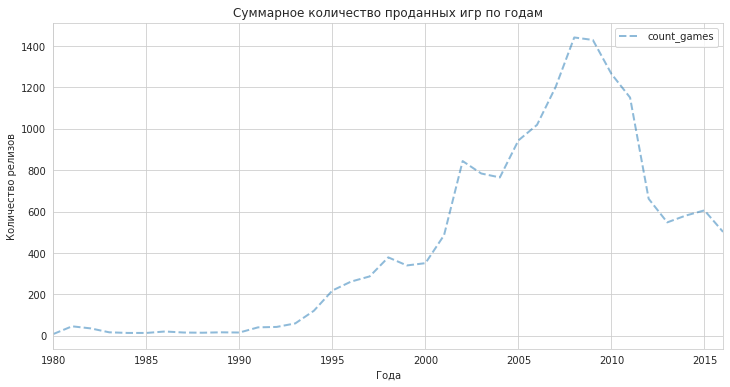

In [77]:
#Построим график
games_year_piv.plot(y='count_games', style='--', grid=True, figsize=(12, 6), lw=2, alpha=0.5)
plt.title('Суммарное количество проданных игр по годам')
plt.ylabel('Количество релизов')
plt.xlabel('Года')
plt.show()

Основной пик продаж обычно бывает в год выпуска и мы относим продажи к году выхода игры.

По графику видно, что количество релизов игр до 1995 года не так велико, игр выпускалось до 200, этот период не показателен и можем рассматривать только период от 1995.

Посмотрим, как менялись продажи по платформам и по годам. Для этого выберем самые популярные платформы.

In [78]:
#Сводная таблица для количества игр по платформам
games_pl = games.pivot_table(index = ['platform'], values = ['sales'] , aggfunc=['sum'])
games_pl.columns = ['sum']
games_pl = games_pl.sort_values(by = 'sum', ascending = False)
print('Всего количество платформ -', games_pl.shape[0])

Всего количество платформ - 31


Поскольку платформ много, 31, выберем для анализа самые популярные 5 платформ.

In [79]:
games_pl_max = games_pl.iloc[:5]
games_pl_max

,sum
platform,
ps2,1054.67
x360,881.27
wii,823.92
ps3,800.09
ds,744.51


In [80]:
#Cоздадим сводную таблицу, в которой только эти платформы
games_pl_piv =  games.query('platform in @games_pl_max.index & year_of_release > 1995').pivot_table(index = ['year_of_release'], columns = ['platform'], values = ['sales'] , aggfunc=['sum'])
games_pl_piv

sum                                
                  sales                                
platform             ds     ps2     ps3     wii    x360
year_of_release                                        
2000                NaN   35.59     NaN     NaN     NaN
2001                NaN  149.65     NaN     NaN     NaN
2002                NaN  186.26     NaN     NaN     NaN
2003                NaN  171.14     NaN     NaN     NaN
2004              15.91  172.79     NaN     NaN     NaN
2005             119.34  141.52    0.15     NaN    8.51
2006             111.64   89.70   17.78  126.37   47.36
2007             136.12   52.40   62.48  139.79   86.68
2008             134.42   34.59  102.03  162.17  123.29
2009             110.82   16.24  113.08  189.43  109.74
2010              79.79    4.44  122.06  117.79  156.28
2011              24.02    0.35  136.21   54.50  132.38
2012              11.01     NaN   91.64   21.33   92.34
2013               1.42     NaN   95.85    7.87   80.82
2014                NaN     NaN   40.88    3.45   31.61
2015                NaN     NaN   14.70    1.05   10.86
2016                NaN     NaN    3.23    0.17    1.40

In [27]:
#Функция для графиков
#Напишем функцию, строящую графики типа plot
#датасет, название, ось х, ось у
    
def print_plot(x_data, title="", xl="", yl="" ):    
    x_data.plot(linewidth=3, alpha=0.7, figsize=(15,10), grid = True)
    ax = plt.axes() 
    ax.set_title(title) #подписали заголовок
    plt.xlabel(xl) #подписали ось х
    plt.ylabel(yl) #подписали ось y
    plt.legend()
    plt.show()    

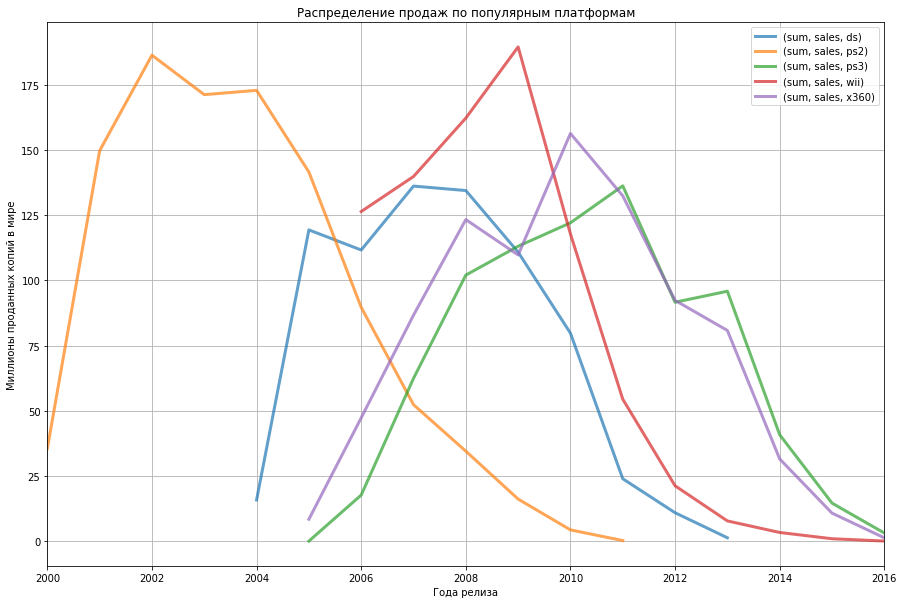

In [28]:
#Построим график
#датасет, название, ось х, ось у
print_plot(games_pl_piv, 'Распределение продаж по популярным платформам', 'Года релиза', 'Миллионы проданных копий в мире')

Судя по графику, распределения похожи на нормальное со смещением вправо. Подъем продаж более быстрый, чем спад, в основном за 2-3 года достигает пика по каждой платформе (кроме ps3, там более длительный подъем), около 2-3х лет находится вблизи пика, далее спад постепенный. В среднем, жизненный цикл платформ 10 лет. Помимо этого, данные за 2016 год могут быть неполными, поэтому наблюдается снижение по всем платформам к 2016.

Чтобы спрогнозировать продажи на 2017 год, стоит выбрать интервал 2014-2016, период в 3 года показателен для оценки, понятна тенденция - рост, пик или спад. 

In [29]:
#Cоздадим таблицу games_act, в которой только актуальные для анализа года: 2014-2016
games_act = games.query('year_of_release > 2013')
print('Количество записей за предыдущие 3 года -', games_act.shape[0])

Количество записей за предыдущие 3 года - 1689


Посмотрим, какие платформы лидируют по продажам.

In [30]:
#Сводная таблица для суммарных продаж игр по платформам за 2014-2016 года
games_act_pl = games_act.pivot_table(index = ['platform'], values = ['sales'] , aggfunc=['sum'])
games_act_pl.columns = ['sum_pl']
games_act_pl = games_act_pl.sort_values(by = 'sum_pl', ascending = False)
print('Всего количество платформ -', games_act_pl.shape[0])
games_act_pl

Всего количество платформ - 10


,sum_pl
platform,
ps4,243.67
xone,127.84
3ds,83.00
ps3,58.81
x360,43.87
wiiu,39.82
pc,25.20
psv,20.59
wii,4.67


По продажам лидируют ps4, xone, 3ds, ps3, x360. Но что с их динамикой продаж? Рассмотрим ее на графиках.

In [31]:
#Cоздадим сводную таблицу для графика
games_act_pl_piv = games_act.pivot_table(index = ['year_of_release'], columns = ['platform'], values = ['sales'] , aggfunc=['sum'])
games_act_pl_piv

sum                                                         \
                 sales                                                          
platform           3ds     pc    ps3     ps4   psp    psv   wii   wiiu   x360   
year_of_release                                                                 
2014             41.75  12.38  40.88   84.22  0.24  10.56  3.45  20.35  31.61   
2015             26.75   7.93  14.70  100.44  0.12   5.93  1.05  15.22  10.86   
2016             14.50   4.89   3.23   59.01   NaN   4.10  0.17   4.25   1.40   

                        
                        
platform          xone  
year_of_release         
2014             49.26  
2015             54.67  
2016             23.91

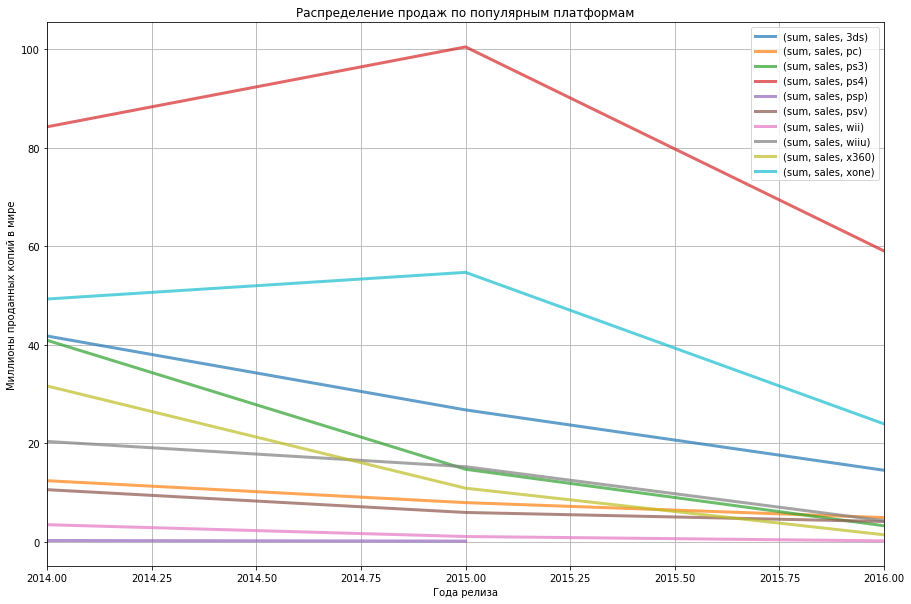

In [32]:
#Построим распределение продаж по годам по самым популярным платформам 
#датасет, название, ось х, ось у
print_plot(games_act_pl_piv, 'Распределение продаж по популярным платформам', 'Года релиза', 'Миллионы проданных копий в мире')

Видна тенденция к снижению объемов продаж. Стоит рассмотреть три самые крупные платформы: ps4, xone, 3ds. Это лидеры по продажам. Но на графике сливаются более мелкие игроки, создадим отдельный график для них и посмотрим тенденции, у каких из менее популярных платформ скорость падения продаж ниже.

In [33]:
#Cоздадим сводную таблицу для менее популярных платформ
games_act_pl_min = games_act_pl.iloc[3:]
games_act_pl_min_piv =  games_act.query('platform in @games_act_pl_min.index').pivot_table(index = ['year_of_release'], columns = ['platform'], values = ['sales'] , aggfunc=['sum'])
games_act_pl_min_piv

sum                                        
                 sales                                        
platform            pc    ps3   psp    psv   wii   wiiu   x360
year_of_release                                               
2014             12.38  40.88  0.24  10.56  3.45  20.35  31.61
2015              7.93  14.70  0.12   5.93  1.05  15.22  10.86
2016              4.89   3.23   NaN   4.10  0.17   4.25   1.40

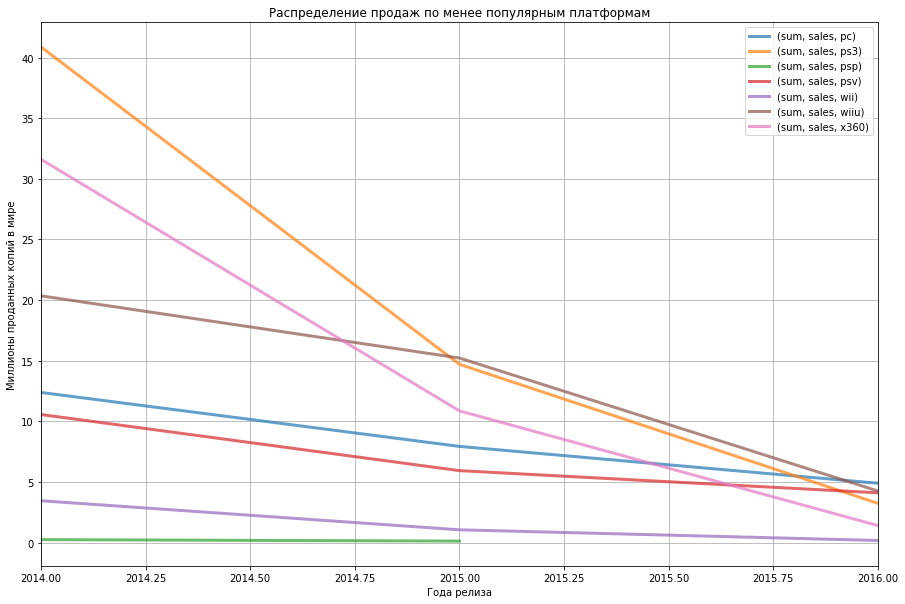

In [34]:
#Построим распределение продаж по годам по не самым популярным платформам 
#датасет, название, ось х, ось у
print_plot(games_act_pl_min_piv, 'Распределение продаж по менее популярным платформам', 'Года релиза', 'Миллионы проданных копий в мире')

Хотя по объему продаж, как мы видели выше, крупнее были ps3, x360, но у них более ярко выражена тенденция к снижению.
Несмотря на то, что ps3 в 2014 году смотрелся перспективнее, чем pc, к 2016 году pc опережает по продажам. Получается, стоит рассмотреть еще 2 платформы, у которых скорость снижения продаж наименьшая: psv, pc. Данные за 2016 год могут быть неполные, поэтому стоит уточнить графики, если будут предоставлены более полные данные позже.

Итого, 5 перспективных платформ:

ps4, xone, 3ds, psv, pc

Построим график boxplot по глобальным продажам игр в разбивке по платформам

In [35]:
#5 перспективных платформ
persp_pl = ['ps4', 'xone', '3ds', 'psv', 'pc']
games_act.query('platform in @persp_pl').sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
13270,child of light,ps4,2014,Role-Playing,0.00,0.01,0.04,0.00,82.0,8,E10+,0.05
16554,"horse life 4: my horse, my friend, my champion",3ds,2015,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
14897,senran kagura: bon appétit!,psv,2014,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03
16345,farming simulator 15 expansion pack,pc,2015,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
14207,duke nukem 3d: 20th anniversary world tour,ps4,2016,Shooter,0.03,0.00,0.00,0.01,77.0,6.9,M,0.03


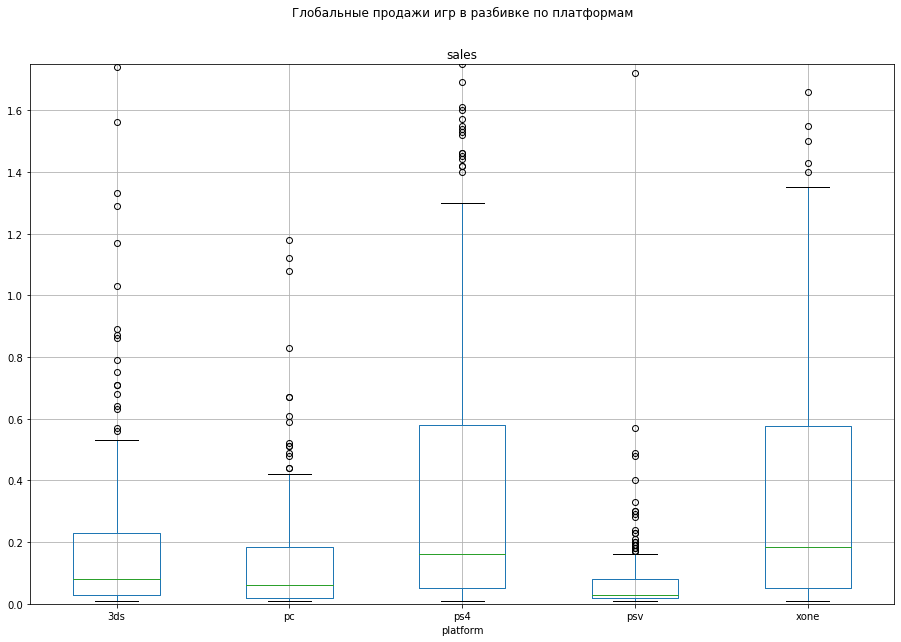

In [36]:
#Построим графики типа "ящик с усами" для пяти перспективных платформ
games_act.query('platform in @persp_pl').boxplot('sales', by = 'platform', figsize=(15,10))
plt.suptitle('Глобальные продажи игр в разбивке по платформам')
plt.ylim(0, 1.75)
plt.show()

За период 3 года:
По двум крупнейшим платформам ps4, xone медианные значения по продажам игр около 200тыс.
Верхние "усы" заканчиваются около 1,35млн — это 1.5 межквартильного размаха, добавленного к 3-му квартилю и ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. 
По другим трем платформам медианы продаж игр около и ниже 50тыс, третий квартиль около 200тыс для 3ds и pc и меньше 100тыс для psv. Наиболее перспективные платформы ps4, xone.

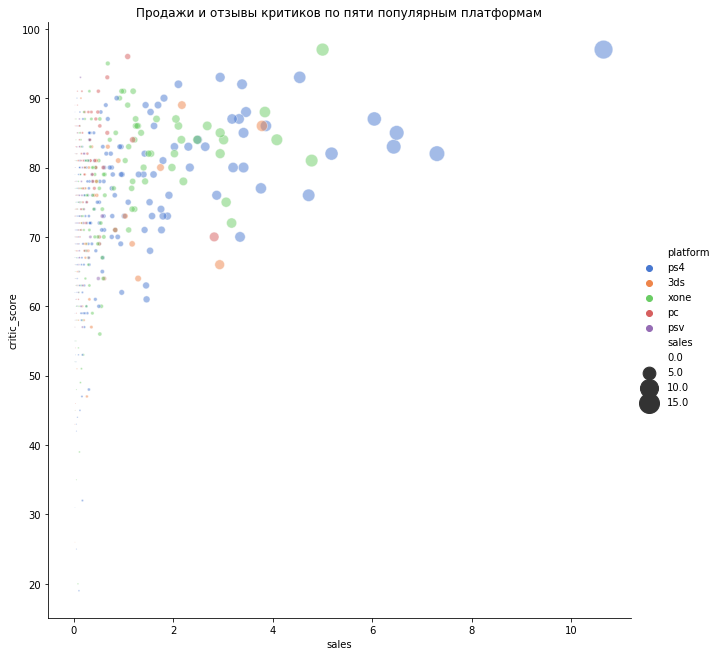

In [37]:
# Посмотрим, как коррелируют продажи и отзывы критиков
sns.relplot(x="sales", y="critic_score", hue="platform", size="sales",
            sizes=(0, 400), alpha=.5, palette="muted",
            height=9, data=games_act.query('platform in @persp_pl'))
plt.title('Продажи и отзывы критиков по пяти популярным платформам')
plt.show()
print()

Подробнее рассмотрим корреляцию для каждой платформы.

In [38]:
#Функция для диаграмм рассеяния
#Напишем функцию, строящую графики типа scatter
    
def print_plot(pl):
    data = games_sc.query('platform == @pl & year_of_release > 2013') #Название платформы
    fig = plt.figure(figsize=(15,5)) 
    ax1 = fig.add_subplot(1,2,1) #Задаем оси1
    ax2 = fig.add_subplot(1,2,2) #Задаем оси2
    fig.tight_layout()

    data.plot(x='sales', y='critic_score', kind='scatter', alpha=1, ax=ax1) #Критики
    data.plot(x='sales', y='user_score', kind='scatter', alpha=1, ax=ax2) #Пользователи
    ax1.set_title('Корреляция продаж и рейтинга критиков') #Заголовок1
    ax2.set_title('Корреляция продаж и рейтинга пользователей') #Заголовок2
    plt.show()

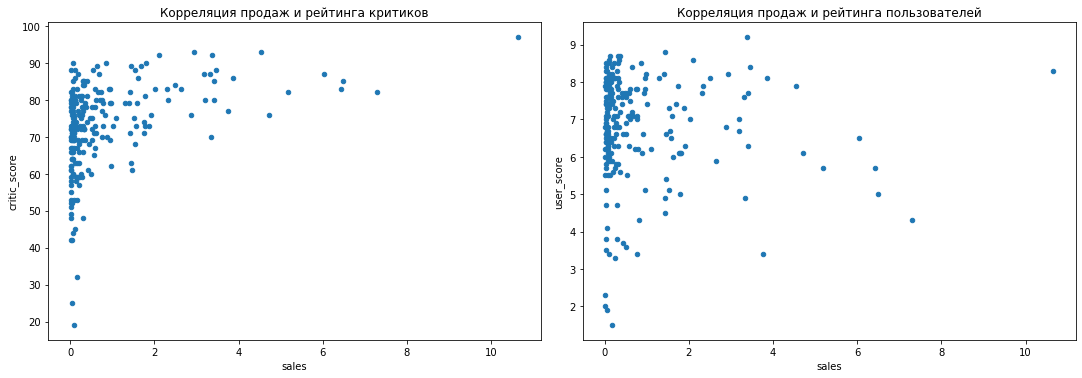

In [39]:
#График для платформы ps4
print_plot("ps4")

In [40]:
#Оценим коэффициент корреляции Пирсона для рейтинга критиков, рейтинга пользователей и объемом продаж для ps4
print(games_sc.query('platform == "ps4"')[['critic_score','user_score', 'sales']].corr()) 

              critic_score  user_score     sales
critic_score      1.000000    0.572802  0.402913
user_score        0.572802    1.000000 -0.030217
sales             0.402913   -0.030217  1.000000


По платформе ps4 между продажами и рейтингом критиков корреляция слабая, положительная. Между продажами и рейтингом пользователей корреляция обратная и очень слабая, можно не учитывать. Между рейтингом пользователей и критиков корреляция положительная, средняя.

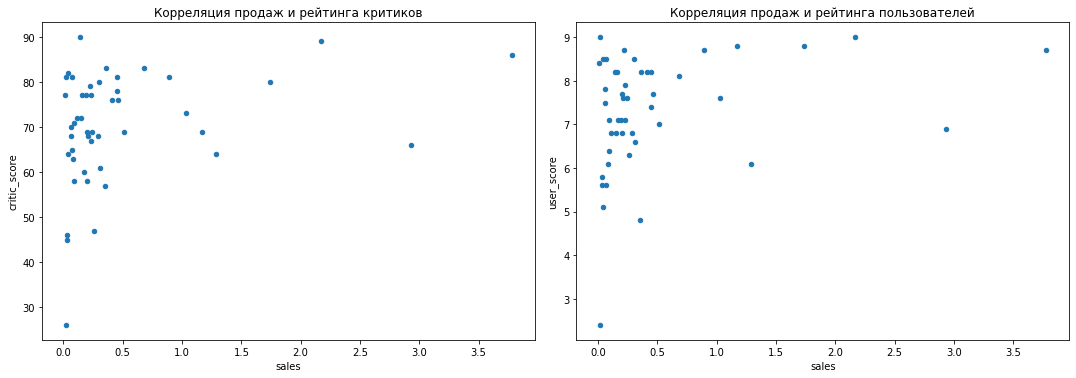

In [41]:
#График для платформы 3ds
print_plot("3ds")

In [42]:
#Оценим коэффициент корреляции Пирсона для рейтинга критиков, рейтинга пользователей и объемом продаж для 3ds
print(games_sc.query('platform == "3ds"')[['critic_score','user_score', 'sales']].corr()) 

              critic_score  user_score     sales
critic_score      1.000000    0.755306  0.340089
user_score        0.755306    1.000000  0.235270
sales             0.340089    0.235270  1.000000


По платформе 3ds между продажами и рейтингом критиков корреляция слабая, положительная. Между продажами и рейтингом пользователей корреляция слабее. Между рейтингом пользователей и критиков корреляция положительная, высокая.

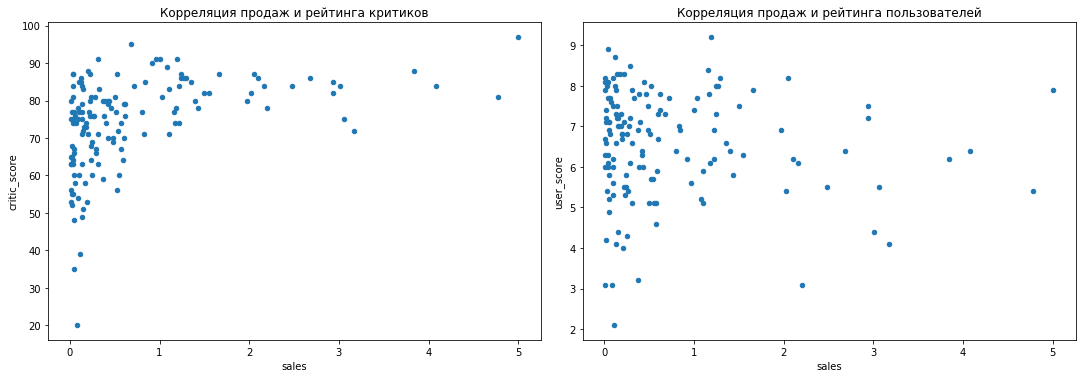

In [43]:
#График для платформы xone
print_plot("xone")

In [44]:
#Оценим коэффициент корреляции Пирсона для рейтинга критиков, рейтинга пользователей и объемом продаж для xone
print(games_sc.query('platform == "xone"')[['critic_score','user_score', 'sales']].corr()) 

              critic_score  user_score     sales
critic_score      1.000000    0.491255  0.410175
user_score        0.491255    1.000000 -0.075564
sales             0.410175   -0.075564  1.000000


По платформе xone между продажами и рейтингом критиков корреляция слабая, положительная. Между продажами и рейтингом пользователей корреляция очень слабая и отрицательная. Между рейтингом пользователей и критиков корреляция слабая.

В итоге, по популярным платформам по корреляции можно сделать вывод, что корреляция между рейтингами критиков и продажами  выше, чем между рейтингом пользователей и продажами.
Чаще всего, есть корреляция между рейтингами пользователей и критиков. 

Посмотрим на распределение игр по жанрам.

In [45]:
#Сводная таблица для группировки по жанрам и перспективным платформам
games_genre = games_act.query('platform in @persp_pl').pivot_table(
                        index=games['genre'], 
                        columns='platform',
                        values= 'sales', 
                        aggfunc='sum')
games_genre

platform,3ds,pc,ps4,psv,xone
genre,,,,,
Action,21.35,4.98,77.64,6.88,28.33
Adventure,1.50,0.37,5.40,2.17,2.47
Fighting,7.60,0.10,6.56,0.64,1.95
Misc,3.72,0.05,6.56,3.07,6.15
Platform,3.74,0.06,4.56,0.16,0.57
Puzzle,0.85,NaN,0.02,0.06,NaN
Racing,NaN,0.61,8.64,0.10,6.35
Role-Playing,38.25,4.52,24.85,5.76,9.59
Shooter,NaN,5.36,66.00,0.49,50.34


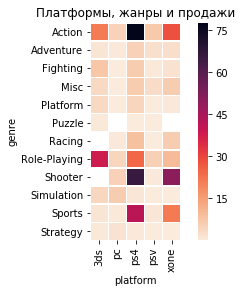

<Figure size 1080x288 with 0 Axes>

In [46]:
#Тепловая карта для группировки по жанрам и перспективным платформам
try:
    sns.heatmap(games_genre, annot=False, fmt=".0f", linewidths=.5, cmap="rocket_r", square = True, cbar_kws={"orientation": "vertical"})
    plt.title('Платформы, жанры и продажи')
    plt.figure(figsize=(15,4))
    plt.show()
except:
    sns.heatmap(games_genre, annot=False, fmt=".0f", linewidths=.5, square = True, cbar_kws={"orientation": "vertical"})
    plt.title('Платформы, жанры и продажи')
    plt.figure(figsize=(15,4))
    plt.show()

Предварительно, Action продавали чаще всего, этот жанр представлен на всех платформах и является лидером по продажам платформы ps4. Также продаваемым является жанр Shooter, хотя он не представлен на 3ds, уверенно продается на ps4, xone.
Sports и Role-Playing также кажутся перспективными.

Посмотрим совокупное распределение по жарнам.

In [47]:
#подсчитаем количество продаж по жанрам и выразим в процентном отношении
games_sum_genre = games_act.pivot_table(
                        index=games['genre'], 
                        values= 'sales', 
                        aggfunc='sum')
games_sum_genre = games_sum_genre.sort_values(by='sales', ascending = False)
games_sum_genre['sales_%'] = games_sum_genre['sales'] / games_sum_genre['sales'].sum()
games_sum_genre.style.format({'sales_%' : '{:.2%}'})

,sales,sales_%
genre,,
Action,176.79,27.29%
Shooter,149.41,23.06%
Sports,95.12,14.68%
Role-Playing,92.8,14.32%
Misc,33.52,5.17%
Fighting,25.49,3.93%
Racing,24.63,3.80%
Platform,16.28,2.51%
Adventure,15.73,2.43%


Больше всего всего продавали Action и Shooter. В сумме оба этих жанра обеспечили более половины всех продаж. За ними идут жанры Sports и Role-Playing. 

Но, возможно, за высокими продажами стоят показатели пары успешных игр или много игр с низкими продажами, для анализа более корректно найти жанр, где игры стабильно приносят высокий доход - для этого стоит рассмотреть медианные значения по жанрам.

In [48]:
#подсчитаем среднее по продажам по жанрам
games_sum_genre_mean = games_act.pivot_table(
                        index=games['genre'], 
                        values= 'sales', 
                        aggfunc='median')
games_sum_genre_mean = games_sum_genre_mean.sort_values(by='sales', ascending = False)
games_sum_genre_mean

,sales
genre,
Shooter,0.475
Sports,0.170
Fighting,0.115
Platform,0.115
Role-Playing,0.100
Simulation,0.095
Misc,0.090
Action,0.080
Racing,0.080


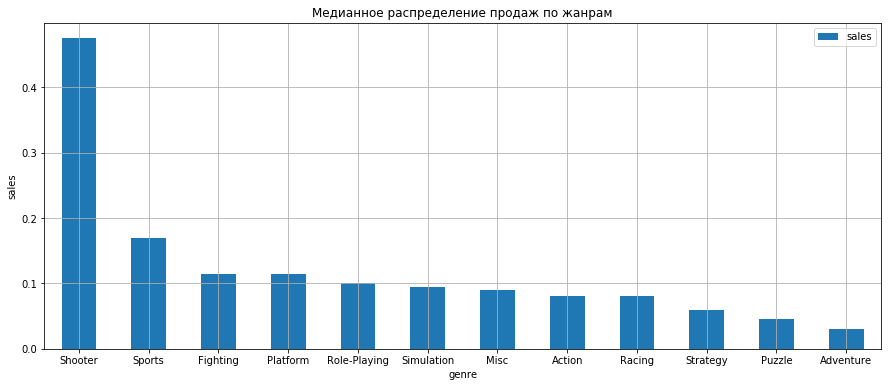

In [49]:
#Построим гистограмму, отражающую распределение по регионам и платформам
ax = games_sum_genre_mean.plot.bar(rot=0, figsize = (15, 6), grid = True)
ax.set_title('Медианное распределение продаж по жанрам') #подписали график
plt.legend()
plt.xlabel('genre') #подписали ось х
plt.ylabel('sales') #подписали ось y
plt.show()

По общему объему продаж, вероятно, из-за игр-хитов, самые продаваемые оказались жанры Action и Shooter. В сумме оба этих жанра обеспечили более половины всех продаж. 

Но при оценке медианных значений оказалось, что стабильно прибыльный жанр — Shooter (не представлен на платформе 3ds). Далее идет Sports, Fighting, Platform, Role-Playing

Самые продаваемые игры - требующие активных действий, отличающиеся активным темпом, имеющие акцент на борьбе и соревновании. Наименее интересны пользователям были жанры Puzzle и Strategy, Adventure, требующие сосредоточенности и тактического подхода. 

### Вывод

Для нашего исследования, чтобы спрогнозировать наиболее популярный продукт и рекламную кампанию на 2017 год, рассматривали три предыдущие года. За этот срок тенденция (рост, пик или спад) обычно сохраняется. Подъем продаж по каждой платформе более быстрый, чем спад, в основном за 2-3 года достигает пика по каждой платформе. В среднем, жизненный цикл платформ 10 лет. 

Видна тенденция к снижению объемов продаж по всем платформам.

Рассмотрели 5 наиболее крупных платформ: ps4, xone, 3ds, psv, pc. Наиболее перспективные платформы: ps4, xone.

По этим платформам провели исследование корреляции и можно сделать вывод, что корреляция между рейтингами критиков и продажами выше, чем между рейтингом пользователей и продажами.

По перспективным платформам ps4 и xone наиболее популярным является жанр Shooter. За ним существенно менее популярными оказываются Sports, Fighting, Platform, Role-Playing. 

## Портрет пользователя каждого региона

Для пользователя каждого региона определим самые популярные платформы

In [50]:
#Сводная таблица для 5 самых популярных платформ в Северной Америке
games_act_na = games_act.pivot_table(index = ['platform'], values = ['na_sales'] , aggfunc=['sum'])
games_act_na.columns = ['na_sum']
games_act_na = games_act_na.sort_values(by = 'na_sum', ascending = False)
games_act_na['sales_%'] = games_act_na['na_sum'] / games_act_na['na_sum'].sum()
games_act_na.iloc[:5].style.format({'sales_%' : '{:.2%}'})

,na_sum,sales_%
platform,,
ps4,98.61,34.71%
xone,81.27,28.61%
x360,28.3,9.96%
3ds,22.64,7.97%
ps3,22.05,7.76%


In [51]:
#Сводная таблица для 5 самых популярных платформ в Европе
games_act_eu = games_act.pivot_table(index = ['platform'], values = ['eu_sales'] , aggfunc=['sum'])
games_act_eu.columns = ['eu_sum']
games_act_eu = games_act_eu.sort_values(by = 'eu_sum', ascending = False)
games_act_eu['sales_%'] = games_act_eu['eu_sum'] / games_act_eu['eu_sum'].sum()
games_act_eu.iloc[:5].style.format({'sales_%' : '{:.2%}'})

,eu_sum,sales_%
platform,,
ps4,130.04,48.04%
xone,46.25,17.09%
ps3,25.54,9.44%
pc,17.97,6.64%
3ds,16.12,5.96%


In [52]:
#Сводная таблица для 5 самых популярных платформ в Японии
games_act_jp = games_act.pivot_table(index = ['platform'], values = ['jp_sales'] , aggfunc=['sum'])
games_act_jp.columns = ['jp_sum']
games_act_jp = games_act_jp.sort_values(by = 'jp_sum', ascending = False)
games_act_jp['sales_%'] = games_act_jp['jp_sum'] / games_act_jp['jp_sum'].sum()
games_act_jp.iloc[:5].style.format({'sales_%' : '{:.2%}'})

,jp_sum,sales_%
platform,,
3ds,44.24,47.52%
ps4,15.02,16.13%
psv,14.54,15.62%
ps3,11.22,12.05%
wiiu,7.31,7.85%


In [53]:
#Сводная таблица для 5 самых популярных платформ для всех регионов
games_act_all = games_act.pivot_table(index = ['platform'], values = ['na_sales', 'eu_sales', 'jp_sales'] , aggfunc=['sum'])
games_act_all['sum_sales'] = games_act_all['sum', 'eu_sales']+games_act_all['sum', 'jp_sales']+games_act_all['sum', 'na_sales']
games_act_all['sum_sales_%'] = games_act_all['sum_sales'] / games_act_all['sum_sales'].sum()
games_act_all.columns = ['eu_sales','jp_sales','na_sales','sum_sales','sum_sales_%']
games_act_all = games_act_all.sort_values(by='sum_sales', ascending = False)
games_act_all.iloc[:5].style.format({'sum_sales_%': '{:.2%}'})

,eu_sales,jp_sales,na_sales,sum_sales,sum_sales_%
platform,,,,,
ps4,130.04,15.02,98.61,243.67,37.61%
xone,46.25,0.32,81.27,127.84,19.73%
3ds,16.12,44.24,22.64,83,12.81%
ps3,25.54,11.22,22.05,58.81,9.08%
x360,15.49,0.08,28.3,43.87,6.77%


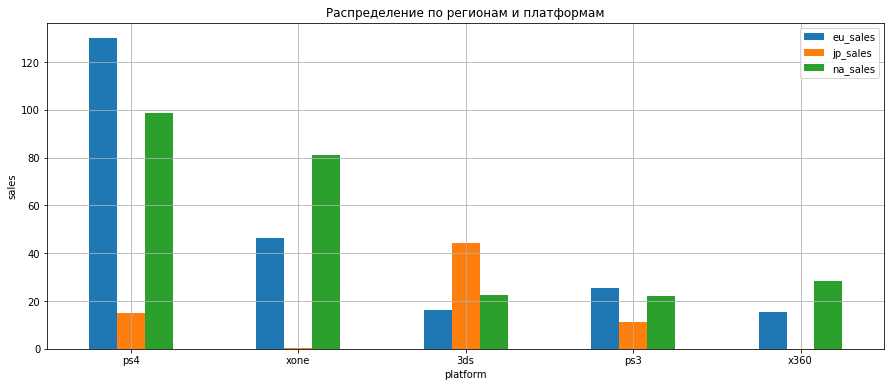

In [54]:
#Построим гистограмму, отражающую распределение по регионам и платформам
ax = games_act_all.iloc[:5, :3].plot.bar(rot=0, figsize = (15, 6), grid = True)
ax.set_title('Распределение по регионам и платформам') #подписали график
plt.legend()
plt.xlabel('platform') #подписали ось х
plt.ylabel('sales') #подписали ось y
plt.show()

В европейском регионе самая популярная платформа ps4, почти 50% рынка и проданных копий игр по ней больше, чем в Северной Америке. В Европе ps4 значительно отрывается от конкурентов. Для Северной Америки ps4 также самая популярная платформа (35%), но разрыв между ней и ближайшим конкурентом xone не так высок. В Японии самая популярная платформа 3ds, 47% рынка. В Японии количество проданных ирг на ps3 и ps4 практически одинаково, хотя в Европе и США ps4 значительно популярнее.

Определим для пользователей каждого региона самые популярные жанры

In [55]:
#Сводная таблица для 5 самых популярных жанров в Северной Америке
games_act_na_genre = games_act.pivot_table(index = ['genre'], values = ['na_sales'] , aggfunc=['sum'])
games_act_na_genre.columns = ['na_sum']
games_act_na_genre = games_act_na_genre.sort_values(by = 'na_sum', ascending = False)
games_act_na_genre['sales_%'] = games_act_na_genre['na_sum'] / games_act_na_genre['na_sum'].sum()
games_act_na_genre.iloc[:5].style.format({'sales_%' : '{:.2%}'})

,na_sum,sales_%
genre,,
Shooter,79.02,27.82%
Action,72.53,25.53%
Sports,46.13,16.24%
Role-Playing,33.47,11.78%
Misc,15.05,5.30%


In [56]:
#Сводная таблица для 5 самых популярных жанров в Европе
games_act_eu_genre = games_act.pivot_table(index = ['genre'], values = ['eu_sales'] , aggfunc=['sum'])
games_act_eu_genre.columns = ['eu_sum']
games_act_eu_genre = games_act_eu_genre.sort_values(by = 'eu_sum', ascending = False)
games_act_eu_genre['sales_%'] = games_act_eu_genre['eu_sum'] / games_act_eu_genre['eu_sum'].sum()
games_act_eu_genre.iloc[:5].style.format({'sales_%' : '{:.2%}'})

,eu_sum,sales_%
genre,,
Action,74.68,27.59%
Shooter,65.52,24.21%
Sports,45.73,16.89%
Role-Playing,28.17,10.41%
Racing,14.13,5.22%


In [57]:
#Сводная таблица для 5 самых популярных жанров в Японии
games_act_jp_genre = games_act.pivot_table(index = ['genre'], values = ['jp_sales'] , aggfunc=['sum'])
games_act_jp_genre.columns = ['jp_sum']
games_act_jp_genre = games_act_jp_genre.sort_values(by = 'jp_sum', ascending = False)
games_act_jp_genre['sales_%'] = games_act_jp_genre['jp_sum'] / games_act_jp_genre['jp_sum'].sum()
games_act_jp_genre.iloc[:5].style.format({'sales_%' : '{:.2%}'})

,jp_sum,sales_%
genre,,
Role-Playing,31.16,33.47%
Action,29.58,31.78%
Fighting,6.37,6.84%
Misc,5.61,6.03%
Shooter,4.87,5.23%


In [58]:
#Сводная таблица для 5 самых популярных жанров для всех регионов
games_act_all_genre = games_act.pivot_table(index = ['genre'], values = ['na_sales', 'eu_sales', 'jp_sales'] , aggfunc=['sum'])
games_act_all_genre.columns
games_act_all_genre['sum_sales'] = games_act_all_genre['sum', 'eu_sales']+games_act_all_genre['sum', 'jp_sales']+games_act_all_genre['sum', 'na_sales']
games_act_all_genre = games_act_all_genre.sort_values(by='sum_sales', ascending = False)

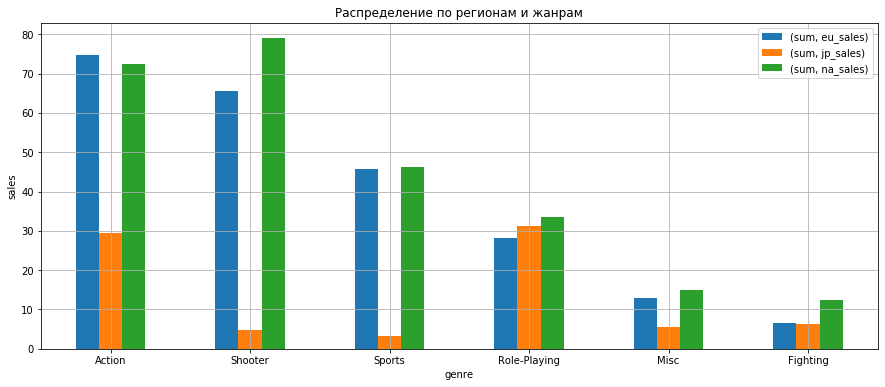

In [59]:
#Построим гистограмму, отражающую распределение по регионам и жанрам
ax = games_act_all_genre.iloc[:6, :3].plot.bar(rot=0, figsize = (15, 6), grid = True)
ax.set_title('Распределение по регионам и жанрам') #подписали график
plt.legend()
plt.xlabel('genre') #подписали ось х
plt.ylabel('sales') #подписали ось y
plt.show()

В Европе и Северной Америке симпатии по жанрам схожи, распределения по предпочтениям более плавное, чем в Японии. 
В Европе больше любят Action, в США - Shooter, но по продажам показатели примерно сопоставимы, 25-27%. Существенно отличаются предпочтения в Японии, там любимый жанр Role-Playing, занимает 34% рынка. Следующий любимый жанр в Японии - Action, 31%. Остальные жанры - уже от 7% рынка и менее. 

Посмотрим, какой рейтинг ESRB популярнее в каждом регионе.

In [60]:
games_rating = games_act.dropna(subset = ['rating'])
games_rating_piv_1 = games_rating.groupby('rating')[['eu_sales', 'jp_sales', 'na_sales']].sum()
games_rating_piv_1[['eu_sales_%', 'jp_sales_%', 'na_sales_%']] = games_rating_piv_1[['eu_sales', 'jp_sales', 'na_sales']] / games_rating_piv_1[['eu_sales', 'jp_sales', 'na_sales']].sum()
games_rating_piv_1.style.format({'eu_sales_%': '{:.2%}', 'jp_sales_%': '{:.2%}', 'na_sales_%': '{:.2%}'})


,eu_sales,jp_sales,na_sales,eu_sales_%,jp_sales_%,na_sales_%
rating,,,,,,
E,58.06,8.94,50.74,27.42%,24.70%,23.13%
E10+,26.16,4.46,33.23,12.36%,12.32%,15.15%
M,93.44,8.01,96.42,44.13%,22.13%,43.96%
T,34.07,14.78,38.95,16.09%,40.84%,17.76%


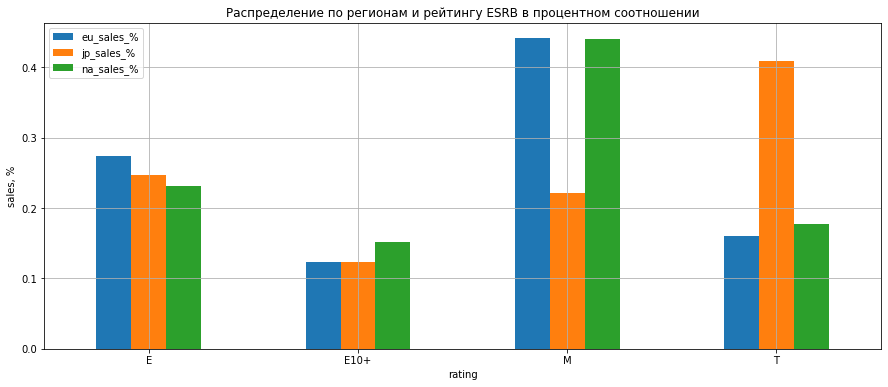

In [61]:
# Посмотрим, как влияют на продажи рейтинг ESRB по регионам
#в процентном соотношении

ax = games_rating_piv_1[['eu_sales_%', 'jp_sales_%', 'na_sales_%']].plot.bar(rot=0, figsize = (15, 6), grid = True)
ax.set_title('Распределение по регионам и рейтингу ESRB в процентном соотношении') #подписали график
plt.legend()
plt.xlabel('rating') #подписали ось х
plt.ylabel('sales, %') #подписали ось y
plt.show()

«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет;

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;

«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет;

«M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет

В Европе и США чаще всего покупают игры категории М, распределение по остальным категориям для этих регионов похоже. В Японии наибольшую популярность имеют игры категории Т.


### Вывод

Составим условный портрет пользователя, отражающий наиболее типичные предпочтения для каждого региона.

Для США это пользователь старше 17 лет, играющий на платформе ps4 или xone, предпочитающий Shooter или Action. В Европе это также пользователь старше 17 лет, скорее всего играющий на платформе ps4, предпочитающий Action или Shooter. Для Японии - от 13 до 17 лет, выбирающий платформу 3ds и играющий Role-Playing или Action.

## Проверка гипотез

Проверим следующие гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Когда генеральных совокупностей две, как при сравнении рейтингов, нужно сопоставить их средние. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var).
Те, вместо расчёта и сравнения самих средних, используем датасеты для проведения статистического теста

Нулевую гипотезу формулируем, как равенство.

Решаем вопрос о принятии или отвержении нулевой гипотезы по p-value, как вероятность ошибки при отклонении нулевой гипотезы. То есть, чем выше p-value тем скорее отклонение нулевой гипотезы будет ошибочным.

Примем критический уровень статистической значимости alpha = 0.05  

#### Нулевая гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Альтернативная гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются

Применяем гипотезу о равенстве средних двух генеральных совокупностей.
Значима ли разница между этими числами, посмотрим по дисперсии выборок, по которым рассчитаны значения

In [62]:
print('Характеристики пользовательского рейтинга xone c 2014 по 2016 годы')
print(games_sc.query('year_of_release > 2013 & platform == "xone"')['user_score'].describe().astype(int))
print('Дисперися для xone', np.var(games_sc.query('year_of_release > 2013 & platform == "xone"')['user_score']))
print('Стандартное отклонение для xone', np.std(games_sc.query('year_of_release > 2013 & platform == "xone"')['user_score']))
print()
print('Характеристики пользовательского рейтинга pc c 2014 по 2016 годы')
print(games_sc.query('year_of_release > 2013 & platform == "pc"')['user_score'].describe().astype(int))
print('Дисперися для pc', np.var(games_sc.query('year_of_release > 2013 & platform == "pc"')['user_score']))
print('Стандартное отклонение для pc', np.std(games_sc.query('year_of_release > 2013 & platform == "pc"')['user_score']))

Характеристики пользовательского рейтинга xone c 2014 по 2016 годы
count    145
mean       6
std        1
min        2
25%        5
50%        6
75%        7
max        9
Name: user_score, dtype: int64
Дисперися для xone 1.7275557669441144
Стандартное отклонение для xone 1.3143651573836377

Характеристики пользовательского рейтинга pc c 2014 по 2016 годы
count    103
mean       6
std        1
min        1
25%        5
50%        6
75%        7
max        9
Name: user_score, dtype: int64
Дисперися для pc 2.9060382693939104
Стандартное отклонение для pc 1.7047106116270616


In [63]:
#Напишем функцию, строящую графики типа distplot
#датасет, название столбца, заголовок графика
def print_distplot(x_data, column, title=""):    
    sns.set_style('whitegrid')
    ax = sns.distplot(x_data.loc[x_data['platform'] == 'xone', column],  bins=50, label='xone')
    sns.distplot(x_data.loc[x_data['platform'] == 'pc', column],  bins=50, ax = ax, label='pc')
    plt.axes().set_title(title)
    plt.Figure(figsize=(7,7))
    plt.legend()
    plt.show()    

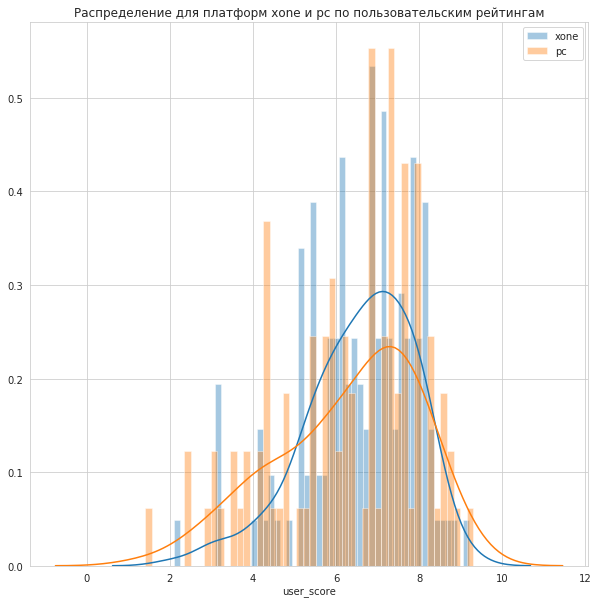

In [64]:
plt.rcParams['figure.figsize']=(10,10)
#датасет, название столбца, заголовок графика
print_distplot(games_sc.query('year_of_release > 2013'), 'user_score', 'Распределение для платформ xone и pc по пользовательским рейтингам')

Медианы выборок на первый взгляд одинаковы, распределения по графикам похожи, но нужно провести статистический тест. Дисперсии совокупностей отличаются, поэтому параметр equal_var нужно указать как False

In [65]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(games_sc.query('year_of_release > 2013 & platform == "xone"')['user_score'], 
                       games_sc.query('year_of_release > 2013 & platform == "pc"')['user_score'], 
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.1498449186136679
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза скорее всего верна, с большой долей вероятности можно сказать, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#### Нулевая гипотеза 2: Средние пользовательские рейтинги жанров Action  и Sports одинаковы
Альтернативная гипотеза 2: Средние пользовательские рейтинги жанров Action и Sports отличаются

Применяем гипотезу о равенстве средних двух генеральных совокупностей.
Значима ли разница между этими числами, посмотрим по дисперсии выборок.

In [66]:
print('Характеристики пользовательского рейтинга жанра Action c 2014 по 2016 годы')
print(games_sc.query('year_of_release > 2013 & genre == "Action"')['user_score'].describe().astype(int))
print('Дисперися для Action', np.var(games_sc.query('year_of_release > 2013 & genre == "Action"')['user_score']))
print('Стандартное отклонение для Action', np.std(games_sc.query('year_of_release > 2013 & genre == "Action"')['user_score']))
print()
print('Характеристики пользовательского рейтинга жанра Sports c 2014 по 2016 годы')
print(games_sc.query('year_of_release > 2013 & genre == "Sports"')['user_score'].describe().astype(int))
print('Дисперися для Sports', np.var(games_sc.query('year_of_release > 2013 & genre == "Sports"')['user_score']))
print('Стандартное отклонение для Sports', np.std(games_sc.query('year_of_release > 2013 & genre == "Sports"')['user_score']))

Характеристики пользовательского рейтинга жанра Action c 2014 по 2016 годы
count    221
mean       6
std        1
min        2
25%        6
50%        7
75%        7
max        9
Name: user_score, dtype: int64
Дисперися для Action 1.8200077803484773
Стандартное отклонение для Action 1.3490766399091185

Характеристики пользовательского рейтинга жанра Sports c 2014 по 2016 годы
count    79
mean      5
std       1
min       1
25%       4
50%       6
75%       6
max       8
Name: user_score, dtype: int64
Дисперися для Sports 2.2313315173850348
Стандартное отклонение для Sports 1.493764210772582


In [67]:
#Напишем функцию, строящую графики типа distplot
#датасет, название столбца, заголовок графика
def print_distplot_1(x_data, column, title=""):    
    sns.set_style('whitegrid')
    ax = sns.distplot(x_data.loc[x_data['genre'] == 'Action', column],  bins=50, label='Action')
    sns.distplot(x_data.loc[x_data['genre'] == 'Sports', column],  bins=50, ax = ax, label='Sports')
    plt.axes().set_title(title)
    plt.Figure(figsize=(7,7))
    plt.legend()
    plt.show()    

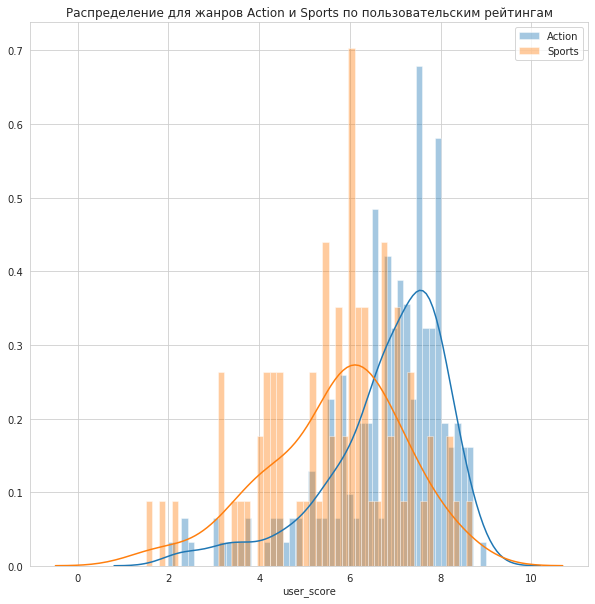

In [68]:
plt.rcParams['figure.figsize']=(10,10)
#датасет, название столбца, заголовок графика
print_distplot_1(games_sc.query('year_of_release > 2013'), 'user_score', 'Распределение для жанров Action и Sports по пользовательским рейтингам')

Медианы выборок на первый взгляд отличаются, грифики распределены визуально со смещением друг относительно друга, проведем статистический тест. Дисперсии совокупностей отличаются, поэтому параметр equal_var нужно указать как False

In [69]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(games_sc.query('year_of_release > 2013 & genre == "Action"')['user_score'], 
                       games_sc.query('year_of_release > 2013 & genre == "Sports"')['user_score'], 
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 3.474253245303909e-08
Отвергаем нулевую гипотезу


Статистический тест показал, что p-значение очень мало и нулевая гипотеза, что средние пользовательские рейтинги жанров Action и Sports одинаковы, скорее всего не верна. 
Скорее всего, средний пользовательский рейтинг жанров Action и Sports отличается. Судя по графику, можем предположить, что средний рейтинг Action выше чем средний рейтинг Sports.

#### Вывод

Результаты статистических тестов не противоречат гипотезе, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые. Нельзя отвергнуть гипотезу, что средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports.

## Общий вывод 

Проведено исследование для интернет-магазина, продающего компьютерные игры. 
Для анализа предоставлены данные из открытых источников, содержащие информацию о продажах игр, оценках пользователей и экспертов, жанрах и платформах за 2016 год и ранее. Целью исследования было выявить определяющие успешность игры закономерности для определения потенциально популярных продуктов и прогнозирования рекламной кампании на 2017-й год. 

Данные были обработаны, проверены на дубликаты, преобразованы к нужному типу, убраны строки с пропущенными значениями. Посчитано суммарное значение продаж по всем регионам. Для анализа связанного с рейтингами использовалась таблица games_sc, в которой отсутствуют пропуски в столбцах, связанных с рейтингами.

В исследовании рассматривались данные за три предыдущие года. За этот срок тенденция (рост, пик или спад) обычно сохраняется. Подъем продаж по каждой платформе более быстрый, чем спад, в основном за 2-3 года достигает пика по каждой платформе.
В среднем, жизненный цикл платформ 10 лет, популярность всех представленных в исследовании платформ снижается к 2017.

Были определены 5 наиболее крупных платформ: ps4, xone, 3ds, psv, pc. Самые крупные платформы: ps4 и xone.

По этим платформам проведено исследование корреляции, которое показало, что зависимость между рейтингами критиков и продажами выше, чем между рейтингом пользователей и продажами, поэтому для определения потенциально популярных продуктов во внимание стоит принимать скорее рейтинг критиков, чем пользователей.

1. Определения перспективных продуктов и платформ по всем регионам.
Наиболее перспективные платформы: ps4 (37% рынка), xone (20% рынка), 3ds (13% рынка)
По перспективным платформам ps4 и xone по всем регионам наиболее популярными является жанр Shooter (около 47% продаж). В совокупности по всем регионам наименее интересны пользователям были жанры Puzzle, Strategy, Adventure.
Хотя в большинстве жанров лидирует ps4, но для Simulation и Strategy лидером является pc. Платформа 3ds популярна в Role-Playing, Fighting, Puzzle, но на ней не представлен самый популярный жанр Shooter. 

2. Определения перспективных продуктов и платформ с разделением по регионам.
В европейском регионе самая популярная платформа ps4, почти 50% рынка. В Европе ps4 значительно отрывается от конкурентов. 
Для Северной Америки ps4 также самая популярная платформа (35% рынка), но разрыв между ней и ближайшим конкурентом xone (28%) не так высок. В Японии самая популярная платформа 3ds (47% рынка). В Японии количество проданных игр на ps3 и ps4 практически одинаково, хотя в Европе и США ps4 значительно популярнее.

    В Европе и Северной Америке симпатии по жанрам схожи, распределения по предпочтениям более плавное, чем в Японии. 
    В Европе больше любят Action, в США - Shooter, но по продажам показатели примерно сопоставимы, 25-27%. Существенно отличаются предпочтения в Японии, там любимый жанр Role-Playing, занимает 34% рынка. Следующий любимый жанр в Японии - Action, 31%. Остальные жанры - уже от 7% рынка и менее. 

    В Европе и США чаще всего покупают игры категории М (около 44% рынка). В Японии наибольшую популярность имеют игры категории Т (40% рынка).

Результаты статистических тестов не противоречат гипотезе, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые. Скорее всего, справедлива гипотеза, что средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports.


**Потенциально популярный продукт на 2017 год:**

Для планирования кампании в США и Европе лучше рассматривать продвижения на платформах ps4 и xone, наиболее преспективный жанр -  Shooter. Возрастная группа, вероятнее всего, старше 17 лет.

Для Японии - лучше выбрать платформу 3ds и ориентироваться на жанр Role-Playing или Action. Возрастная группа, вероятнее всего, от 13 до 17 лет.

Самые продаваемые игры - требующие активных действий, отличающиеся активным темпом, имеющие акцент на борьбе и соревновании.
Поскольку наблюдается снижение объемов продаж по представленным для анализа платформам к 2016 году, следует отслеживать появление перспективных новых платформ. 